In [12]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

# Cargar las variables del archivo .env
load_dotenv()

# Leer la clave API desde el archivo .env
api_key = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)


In [30]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, justification="Why this query is relevant to the user's request.")
    responder: str = Field(None, description="Response from the LLM.")
    search_results: list[str] = Field(None, description="List of search results.")
    search_results_summary: str = Field(None, description="Summary of search results.")

# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("La obediencia a los pastores es totalitaria y unilateral en todo orden de cosas en la iglesia cristiana?")
print(f"SEARCH QUERY: {output.search_query}\n")
print(f"JUSTIFICATION: {output.justification}\n")
print(f"RESPONDER: {output.responder}\n")
print(f"SEARCH RESULTS: {output.search_results}\n")
print(f"SEARCH RESULTS SUMMARY: {output.search_results_summary}")




SEARCH QUERY: obediencia a los pastores en la iglesia cristiana totalitaria unilateral

JUSTIFICATION: Esta consulta busca explorar la dinámica de poder y autoridad dentro de las iglesias cristianas, lo que puede revelar si la obediencia a los pastores es realmente unilateral y totalitaria, y cómo se manifiestan estas obediencias dentro de diferentes denominaciones o comunidades.

RESPONDER: La obediencia a los pastores puede variar significativamente entre diferentes iglesias cristianas. En algunas denominaciones, se promueve una total dependencia y obediencia a la autoridad del pastor, mientras que en otras se fomenta un modelo más colaborativo donde se toman decisiones en conjunto. La percepción de una obediencia unilateral y totalitaria puede surgir en contextos donde los líderes ejercen un control alto sobre los miembros, sin permitir discusión ni objeción, lo que puede ser visto como problemático. Sin embargo, no todas las congregaciones operan de esta manera, y muchas abogan por

# Prompt Chaining

![prompt_chaining](img/prompt_chaining.png "Prompt_chaining")

Each LLM call processes  the putput  of the previous one:
- E.g., when decomposing a task into multiple LLM calls has benefit

## Example

_Take a topic, LLM make a joke, LLM improve the joke, LLM transform a chilean joke._


In [13]:
from typing_extensions import TypedDict

# Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [14]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate a initial joke."""

    msg = llm.invoke(f"Write a short joke about {state['topic']}.")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke."""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def chilean_joke(state: State):
    """Third LLM call for final chilean joke."""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Conditional edge function  to check  if the joke  has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline."""

    # Simple check - does  the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

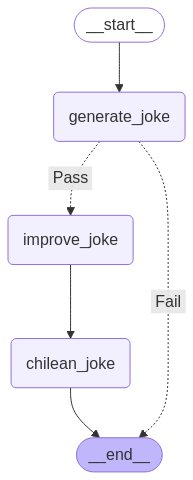

In [15]:
from langgraph.graph import StateGraph, END, START
from IPython.display import display, Image

# Build workflow
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("chilean_joke", chilean_joke)

# Add Edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "chilean_joke")
workflow.add_edge("chilean_joke", END)

# Compile
chain =  workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [16]:
state = chain.invoke({"topic": "ñuñoinos progres"})
print("Inital joke: ")
print(state["joke"])
print("\n--- --- ---")
if "improved_joke" in state:
    print("Improved joke: ")
    print(state["improved_joke"])
    print("\n--- --- ---")

    print("Final joke: ")
    print(state["final_joke"])
else :
    print("Joke failed quality gate - no punchline detetected!")

Inital joke: 
¿Por qué los ñuñoinos progres nunca se pierden? 

Porque siempre están a la "vanguardia" de la conversación.

--- --- ---
Improved joke: 
¿Por qué los ñuñoinos progres nunca se pierden? 

Porque siempre están a la “vanguardia” de la conversación, ¡y nunca les falta la "dirección" correcta!

--- --- ---
Final joke: 
¿Por qué los ñuñoinos progres nunca se pierden? 

Porque siempre están a la “vanguardia” de la conversación, ¡y nunca les falta la "dirección" correcta! Pero si alguna vez se extravían, ¡es porque se detuvieron a debatir si el mapa era inclusivo y sostenible!


# Parallelization
![Parallelization](img/parallelization.png "Parallelization")

- Sub-tasks can be parallelized.
  - E.g., when you want multi-perspectives for one task (multi-query for RAG).
  - E.g., when independent tasks can be performed w/ different prompts.


- Las subtareas pueden paralelizarse.
  - Por ejemplo, cuando se desean múltiples perspectivas para una tarea (consulta múltiple para RAG).
  - Por ejemplo, cuando las tareas independientes pueden realizarse con diferentes indicaciones (prompts).

## Example:
_Take a topic, create a Joke, Story and Poem._


In [17]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [21]:
# Nodes

def generate_joke(state: State):
    """First LLM call to generate a initial joke."""

    msg = llm.invoke(f"Write a short joke about {state['topic']}.")
    return {"joke": msg.content}

def generate_story(state: State):
    """Second LLM call to generate a story."""

    msg = llm.invoke(f"Write a short story about {state['topic']}.")
    return {"story": msg.content}

def generate_poem(state: State):
    """Third LLM call to generate a poem."""

    msg = llm.invoke(f"Write a short poem about {state['topic']}.")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke, story and peom into a single output."""

    combined = f"""This is a combintation of a joke, a story and a poem about {state['topic']}.

JOKE: {state['joke']}

STORY: {state['story']}

POEM: {state['poem']}"""

    return {"combined_output": combined}

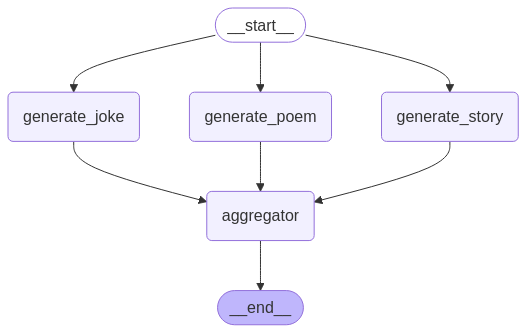

In [22]:
# Build Workflow
parallel_builder = StateGraph(State)

# Add Nodes
parallel_builder.add_node("generate_joke", generate_joke)
parallel_builder.add_node("generate_story", generate_story)
parallel_builder.add_node("generate_poem", generate_poem)
parallel_builder.add_node("aggregator", aggregator)

# Add Edges and connect nodes
parallel_builder.add_edge(START, "generate_joke")
parallel_builder.add_edge(START, "generate_story")
parallel_builder.add_edge(START, "generate_poem")
parallel_builder.add_edge("generate_joke", "aggregator")
parallel_builder.add_edge("generate_story", "aggregator")
parallel_builder.add_edge("generate_poem", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [23]:
state = parallel_workflow.invoke({"topic": "Amor a las hijas"})
print(state["combined_output"])

This is a combintation of a joke, a story and a poem about Amor a las hijas.

JOKE: ¿Por qué a las hijas les encanta el amor? 

¡Porque siempre saben cómo "hija" dejarte sonriendo!

STORY: **Amor a las Hijas**

En un pequeño pueblo rodeado de montañas, vivía una mujer llamada Clara. Desde el día en que se convirtieron en madre, su vida giró en torno a sus dos hijas: Valentina, la mayor, y Sofía, la pequeña. Clara había crecido sin una figura materna en su vida; su madre había fallecido cuando ella era apenas una niña. Gracias a esa experiencia, Clara se prometió ser el mejor ejemplo y el refugio incondicional que sus hijas necesitaran.

Cada mañana, el despertar en la casa era un ritual especial. Las risas de Valentina y Sofía resonaban en la cocina mientras Clara preparaba desayuno. Con el aroma del café y las tostadas recién hechas en el aire, Clara les contaba cuentos antes de ir a la escuela. Las historias hablaban de heroínas valientes, reinos lejanos y aventuras fascinantes, tan 

# Routing

![Routing](img/routing.png "routing")

Routing classifies an input and directs it to a specialized follow-up task.
- E.g., when routing a question to different retrieval systems.

El enrutamiento clasifica una entrada y la dirige a una tarea de seguimiento especializada.
- Por ejemplo, cuando se enruta una pregunta a diferentes sistemas de recuperación.

Example:
- Route an input between joke, story, and poem.







In [31]:
from typing_extensions import Literal
from pydantic import  Field, BaseModel

# Schema for structured output to use  as routing logic
class Route(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(None, description="The next step in the routing process")

# Augment the LLM  with schema  for structured output
router = llm.with_structured_output(Route)
